# Measurements

This notebook contains the measurement protocol used to create a two dimensional intensity distribution with respect to supplied frequencies signals to the two dimensional AOD.

A single sequence comprises a first AOD to be supplied a constant frequency, a second AOD to be configured to sweep a frequency range on an external trigger signal and an oscilloscope connected to a photodiode that triggers on the same external trigger signal supplied to the second AOD.

One measurement contains multiple sequences where the constant frequency is updated linearly to cover the same range as the second AOD but in discrete steps. At the end we exchange the role of the first and second AOD by applying a constant frequency to the second AOD.

In [3]:
import numpy as np

import time
import control

from matplotlib import pyplot as plt

For every sequence we have to prepare the oscilloscope to wait on the external trigger signal and save the measurement to an external drive using a descriptive filename.

We can communicate with the oscilloscope by using the VISA interface.

In [55]:
import visa

rm = visa.ResourceManager()

scope = rm.open_resource('TCPIP::172.22.22.30::inst0::INSTR')
scope.timeout = 5000
scope.clear()

def single():
    scope.write(':SINGle')


def save(filename):
    scope.write(f':SAVE:WMEMory:STARt "\\usb\\{filename}.h5"')

scope.query("*IDN?")

'AGILENT TECHNOLOGIES,MSO-X 4054A,MY57310545,07.20.2017102615\n'

In [101]:
rm.list_resources()

('ASRL1::INSTR', 'ASRL2::INSTR', 'ASRL3::INSTR')

The external trigger signal supplied to the synthesizer and the oscilloscope is generated by beaglebone device with line driver add-on connected to the network.

In [57]:
import requests

def trigger():
    res = requests.get('http://172.22.22.35:6200')

In [96]:
def capture(channel):
    scope.write(':WAVeform:FORMat WORD')
    scope.write(f':WAVeform:SOURce CHANnel{channel}')
    
    xorg = scope.query_ascii_values(':WAVeform:XORigin?')[0]
    xinc = scope.query_ascii_values(':WAVeform:XINcrement?')[0]
    yorg = scope.query_ascii_values(':WAVeform:YORigin?')[0]
    yinc = scope.query_ascii_values(':WAVeform:YINcrement?')[0]
    yref = scope.query_ascii_values(':WAVeform:YREference?')[0]

    values = scope.query_binary_values(':WAVeform:DATA?',
        datatype='h', container=np.array)
    
    U = yorg + yinc*(values+yref)
    t = np.arange(xorg, xorg + len(U)*xinc, xinc)
    
    return t, U

In [160]:
control.horizontal(frequency=100e6, amplitude=1.0)
control.vertical(frequency=100e6, amplitude=1.0)

<Response [204]>

In [213]:
control.vertical(
        frequency=[90e6, 110e6],
        amplitude=1.0*np.ones(1024),
        duration=.270,
        interval=0.000260,
        nodwells=[False, True])

single()

time.sleep(.5)

trigger()

time.sleep(.5)

amplitudes[1.0] = capture(1)

In [ ]:
amplitudes = {}

for i in np.arange(0.3, 1.0+1e-4, 1e-4):
    print(f'acquiring data at amplitude A = {i}')

    control.vertical(
        frequency=[90e6, 110e6],
        amplitude=i*np.ones(1024),
        duration=.270,
        interval=0.000260,
        nodwells=[False, True])

    single()

    time.sleep(.5)

    trigger()

    time.sleep(.5)

    amplitudes[i] = capture(1)

In [216]:
import pandas as pd

time = []
voltage = []
amplitude = []

for a, (t, U) in amplitudes.items():
    amplitude.append(a*np.ones(len(t)))
    time.append(t)
    voltage.append(U)
    
table = {'time': np.concatenate(time), 'voltage': np.concatenate(voltage), 'amplitude': np.concatenate(amplitude)}

pd.DataFrame(table).to_csv('data2.csv')

In [4]:
import pandas as pd

df = pd.read_csv('data2.csv')

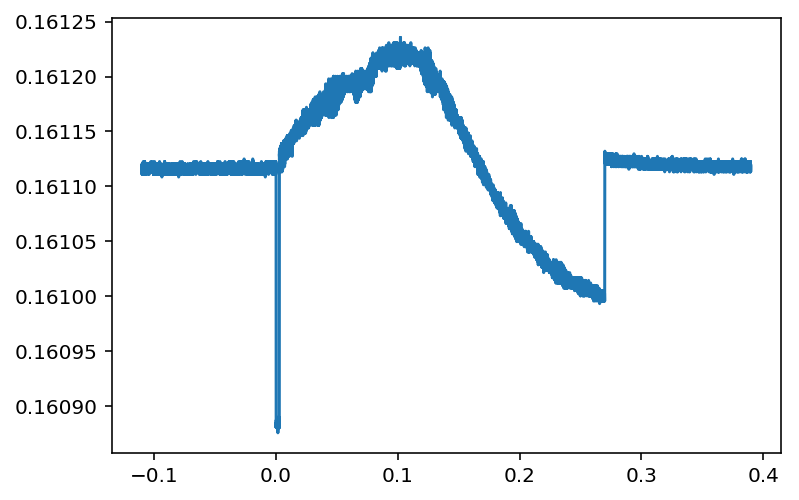

In [5]:
plt.plot(df[df['amplitude'] == 1.0]['time'], df[df['amplitude'] == 1.0]['voltage'])

In [6]:
import util

start, stop = util.argoffset(df[df['amplitude'] == 1.0]['time'], 0, .270)

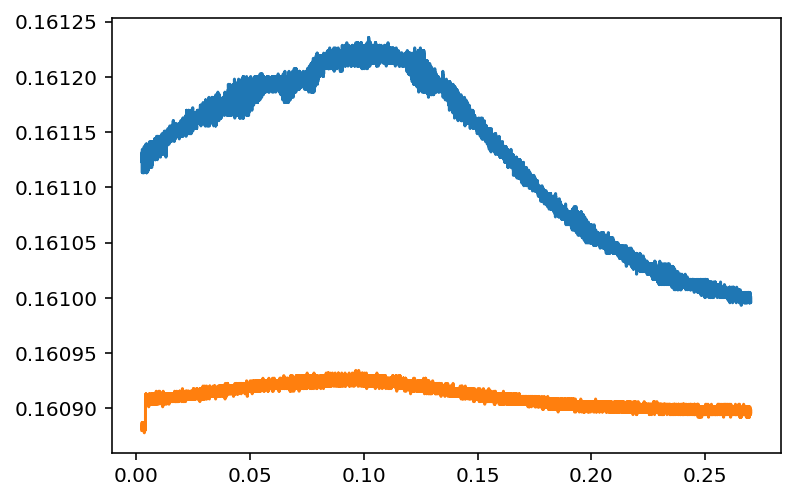

In [15]:
a = start + 344
b = stop - 9

plt.plot(df[df['amplitude'] == 1.0]['time'][a:b], df[df['amplitude'] == 1.0]['voltage'][a:b])
plt.plot(df[df['amplitude'] == 0.3]['time'][a:b], df[df['amplitude'] == 0.3]['voltage'][a:b])

In [33]:
U_target = df[df['amplitude'] == 1.0]['voltage'][a:b].min()
U_target

t0 = df[df['amplitude'] == 1.0]['time'].values[a]
t1 = df[df['amplitude'] == 1.0]['time'].values[b]

df_clipped = df[(df['time'] > t0) & (df['time'] < t1)]
df_clipped.head(5)

,Unnamed: 0,time,voltage,amplitude,voltage_clipped,voltage-difference
14559,14559,0.002676,0.160883,0.3,0.160883,-0.000111
14560,14560,0.002684,0.160885,0.3,0.160885,-0.000108
14561,14561,0.002692,0.160883,0.3,0.160883,-0.000111
14562,14562,0.002699,0.160883,0.3,0.160883,-0.000111
14563,14563,0.002707,0.160887,0.3,0.160887,-0.000106


In [34]:
df_clipped = df_clipped.drop(columns=['Unnamed: 0', 'voltage_clipped', 'voltage-difference'])

In [36]:
df_clipped['voltage-delta'] = np.abs(df['voltage'] - U_target)

In [80]:
df_amp = df.iloc[df_clipped.groupby('time')['voltage-delta'].idxmin()]

In [81]:
df_amp.head(5)

,Unnamed: 0,time,voltage,amplitude,voltage_clipped,voltage-difference
19046779,19046779,0.002676,0.160993,0.595,NaN,NaN
19046780,19046780,0.002684,0.160993,0.595,NaN,NaN
19627425,19627425,0.002692,0.160993,0.604,NaN,NaN
19498394,19498394,0.002699,0.160993,0.602,NaN,NaN
19498395,19498395,0.002707,0.160996,0.602,NaN,NaN


In [82]:
df_final = df_amp.sort_values('time')#df_amp.apply(lambda x: x).sort_values('time')

t = df_final['time']
A = df_final['amplitude']

In [83]:
U = df_final['voltage']

In [89]:
U_target

0.160993165437

In [88]:
df_final.head()

,Unnamed: 0,time,voltage,amplitude,voltage_clipped,voltage-difference
19046779,19046779,0.002676,0.160993,0.595,NaN,NaN
19046780,19046780,0.002684,0.160993,0.595,NaN,NaN
19627425,19627425,0.002692,0.160993,0.604,NaN,NaN
19498394,19498394,0.002699,0.160993,0.602,NaN,NaN
19498395,19498395,0.002707,0.160996,0.602,NaN,NaN


In [91]:
df_final['amplitude'].min(), df_final['amplitude'].max()

(0.4460000000000001, 0.8260000000000005)

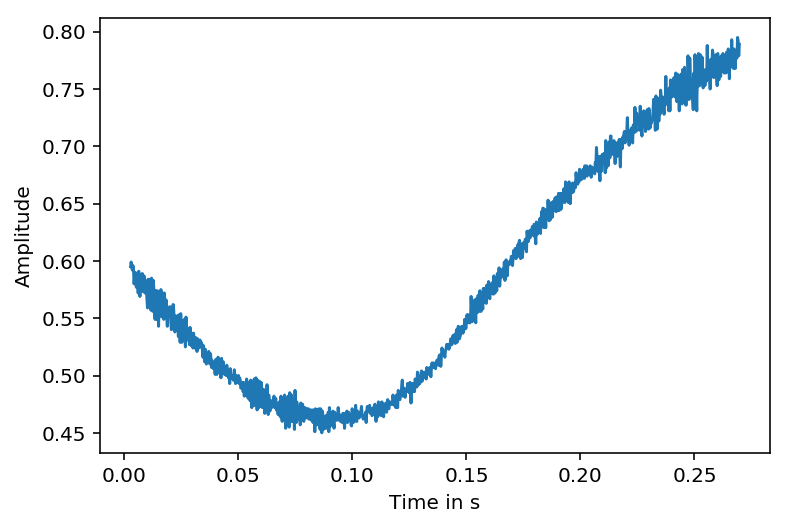

In [106]:
plt.plot(df_final['time'].values[::33], df_final['amplitude'].values[::33])
plt.xlabel('Time in s')
plt.ylabel('Amplitude')
plt.show()

In [99]:
control.vertical(
        frequency=[90e6, 110e6],
        amplitude=df_final['amplitude'].values[::34],
        duration=.270,
        interval=0.000260,
        nodwells=[False, True])

single()

time.sleep(.5)

trigger()

time.sleep(.5)

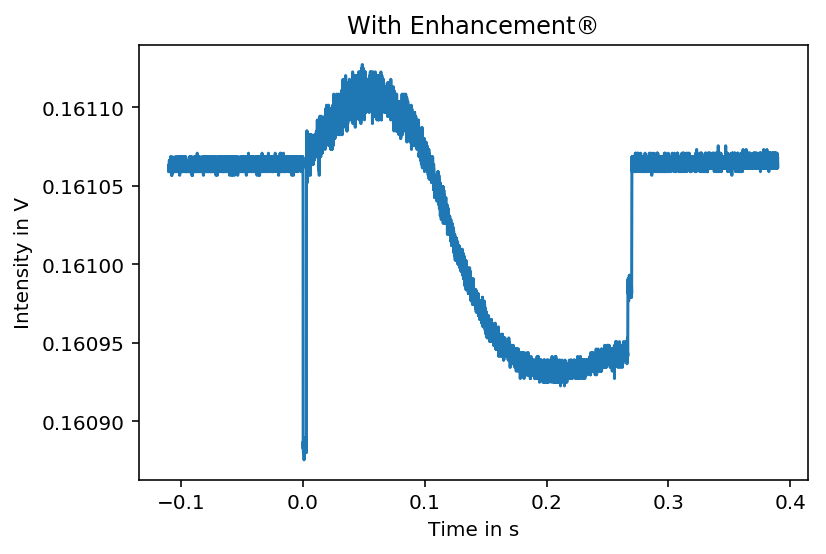

In [100]:
ta, Ua = capture(1)

plt.title('With Enhancement®')
plt.plot(ta, Ua)
plt.xlabel('Time in s')
plt.ylabel('Intensity in V')
plt.show()

In [101]:
df_final['amplitude'].values[::34]

array([0.595, 0.604, 0.589, ..., 0.767, 0.793, 0.786])

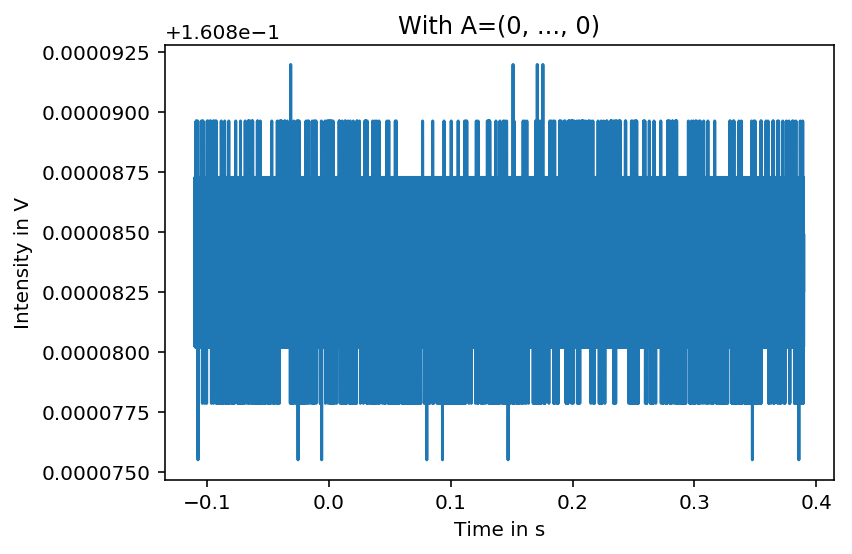

In [103]:
control.vertical(
        frequency=[90e6, 110e6],
        amplitude=np.zeros(1024),
        duration=.270,
        interval=0.000260,
        nodwells=[False, True])

single()

time.sleep(.5)

trigger()

time.sleep(.5)

ta, Ua = capture(1)

plt.title('With A=(0, ..., 0)')
plt.plot(ta, Ua)
plt.xlabel('Time in s')
plt.ylabel('Intensity in V')
plt.show()

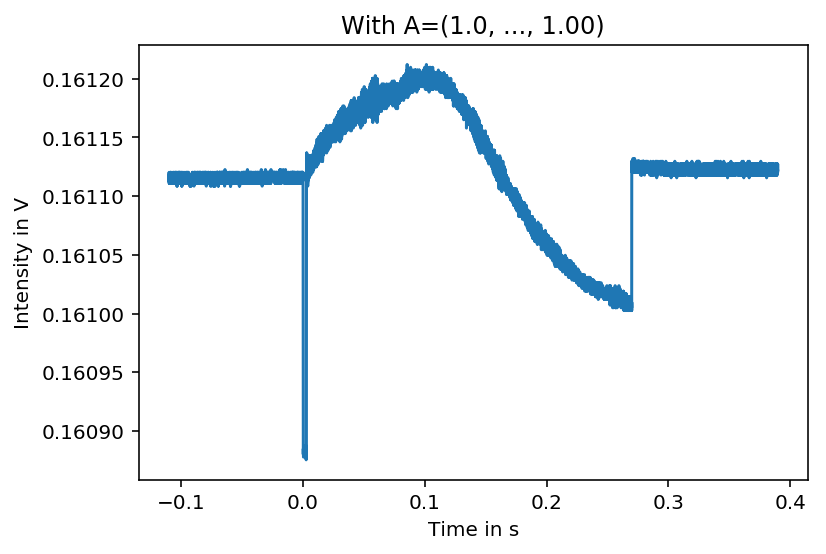

In [105]:
control.vertical(
        frequency=[90e6, 110e6],
        amplitude=1*np.ones(1024),
        duration=.270,
        interval=0.000260,
        nodwells=[False, True])

single()

time.sleep(.5)

trigger()

time.sleep(.5)

ta, Ua = capture(1)

plt.title('With A=(1.0, ..., 1.00)')
plt.plot(ta, Ua)
plt.xlabel('Time in s')
plt.ylabel('Intensity in V')
plt.show()

In [130]:
ndata = {}

for a in np.arange(0.3, 1.0+1e-2, 1e-2):
    print(f'amplitude A={a}')

    control.vertical(
        frequency=100e6,
        amplitude=a)

    single()

    time.sleep(.5)

    trigger()

    time.sleep(.5)

    ndata[a] = capture(1)

amplitude A=0.3
amplitude A=0.31
amplitude A=0.32
amplitude A=0.33
amplitude A=0.34
amplitude A=0.35000000000000003
amplitude A=0.36000000000000004
amplitude A=0.37000000000000005
amplitude A=0.38000000000000006
amplitude A=0.39000000000000007
amplitude A=0.4000000000000001
amplitude A=0.4100000000000001
amplitude A=0.4200000000000001
amplitude A=0.4300000000000001
amplitude A=0.4400000000000001
amplitude A=0.4500000000000001
amplitude A=0.46000000000000013
amplitude A=0.47000000000000014
amplitude A=0.48000000000000015
amplitude A=0.49000000000000016
amplitude A=0.5000000000000002
amplitude A=0.5100000000000002
amplitude A=0.5200000000000002
amplitude A=0.5300000000000002
amplitude A=0.5400000000000003
amplitude A=0.5500000000000003
amplitude A=0.5600000000000003
amplitude A=0.5700000000000003
amplitude A=0.5800000000000003
amplitude A=0.5900000000000003
amplitude A=0.6000000000000003
amplitude A=0.6100000000000003
amplitude A=0.6200000000000003
amplitude A=0.6300000000000003
amplitud

HTTPError: 500 Server Error: Internal Server Error for url: http://172.22.22.24:6200/devices/dds/9

In [121]:
import importlib

importlib.reload(control)

<module 'control' from '/Users/bodokaiser/Repositories/bachelor-thesis/notebooks/control.py'>

In [127]:
control.vertical(frequency=100e6, amplitude=0)

<Response [204]>

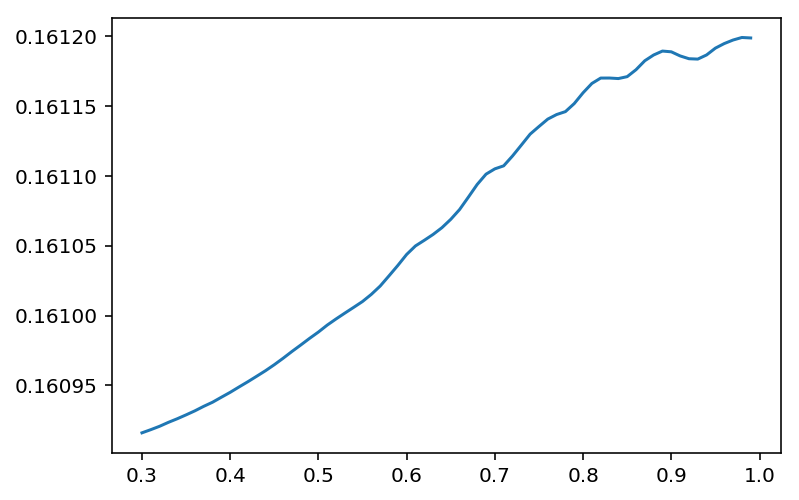

In [135]:
x = []
y = []

for a, (t, U) in ndata.items():
    x.append(a)
    y.append(U.mean())
    
x = np.array(x)
y = np.array(y)

plt.plot(x, y)

In [139]:
u = []
v = []

for 
df_clipped[17242].count() // 2

time             17242
voltage          17242
amplitude        17242
voltage-delta    17242
dtype: int64

In [141]:
df_clipped[df_clipped['amplitude'] == 1.0]['time'].values[17242]

0.13630198687343964

In [143]:
dff = df_clipped[df_clipped['time'] == 0.13630198687343964].sort_values('amplitude')

In [144]:
dff.head()

,time,voltage,amplitude,voltage-delta
31801,0.136302,0.160915,0.300,0.000078
96317,0.136302,0.160913,0.301,0.000080
160833,0.136302,0.160920,0.302,0.000073
225349,0.136302,0.160918,0.303,0.000075
289865,0.136302,0.160915,0.304,0.000078


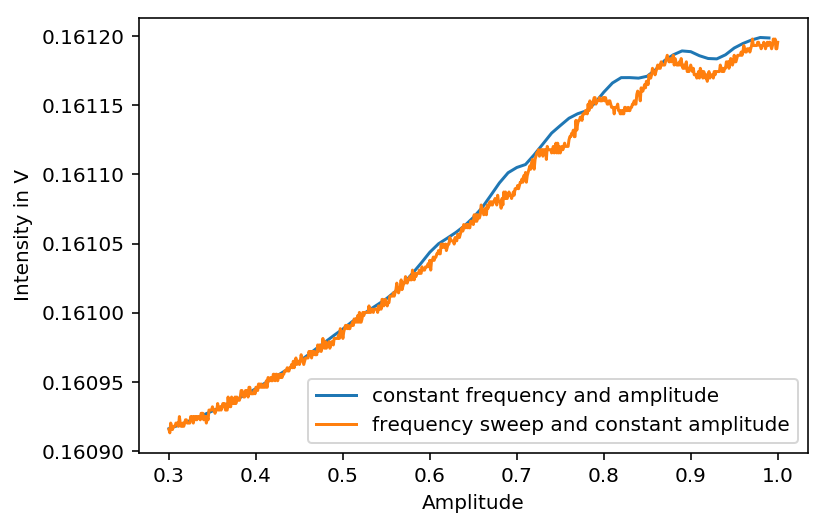

In [149]:
plt.plot(x, y, label='constant frequency and amplitude')
plt.plot(dff['amplitude'], dff['voltage'], label='frequency sweep and constant amplitude')
plt.legend()
plt.xlabel('Amplitude')
plt.ylabel('Intensity in V')
plt.show()